### Topic : Personality Prediction

#### Data Source : https://www.kaggle.com/datasets/datasnaek/mbti-type/data

#### About Data File :
   The Myers–Briggs Type Indicator (MBTI) is a kind of psychological classification about human’s experience. 
     using four principal psychological functions, sensation, intuition, feeling, and thinking, 
        constructed by Katharine Cook Briggs and her daughter Isabel Briggs Myers.
   The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone. 
        into 16 distinct personality types across 4 axes:
        
            * Introversion (I) – Extroversion (E)
            * Intuition (N) – Sensing (S)
            * Thinking (T) – Feeling (F)
            * Judging (J) – Perceiving (P)
            

### Overview
  Organization needs to classify the individuals based on their personality traits. The availability of high dimensional and large amount of date has paved the way for increasing the effectiveness of marketing campaigns by targeting specific people. This will increase the popularity and attractiveness of products and services. Some common examples:
  1. Personalizing the online advertisement campaigns.
  2. Incorporate a personality-based approach to increase the attractiveness of recommended products.
  3. Personality based adaptations can also provide personalized visualization and better music recommendations.
  
  * In this project we will use machine learning to evaluate the MBTIs validity and ability to predict language styles and behaviour online.

In [11]:
!pip install xgboost

In [12]:
# Import Libraries
# Import Libraries
import pandas as pd
import os
import numpy as np
#pip install textblob
from textblob import TextBlob
# pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
# pip install nltk
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import collections
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder  #encoding categorical data to numerical
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [13]:
#!pip install --upgrade scikit-learn

In [14]:
# Read the  dataset  file ('mbti_1.csv') from local:
directory = '/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6' 
# Set the working directory
os.chdir(directory)
print(os.getcwd())
# 1. Import the movie review data as a data frame and ensure that the data is loaded properly.

file_name = "mbti_1.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter=',')

# Display few records.
df.head()

/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [15]:
# Describe the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


    There are only 2 columns in the dataset
    Total no. of rows are 8675
    There are no null values present in the dataset
    One Disadvantage is that all values are textual, hence they have to be converted to numerical form 
    to train the ML model

In [16]:
#displays unique values in type column
df['type'].unique()   

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

* It has 16 distinct personality types

Text(0.5, 1.0, 'Total posts for each personality type')

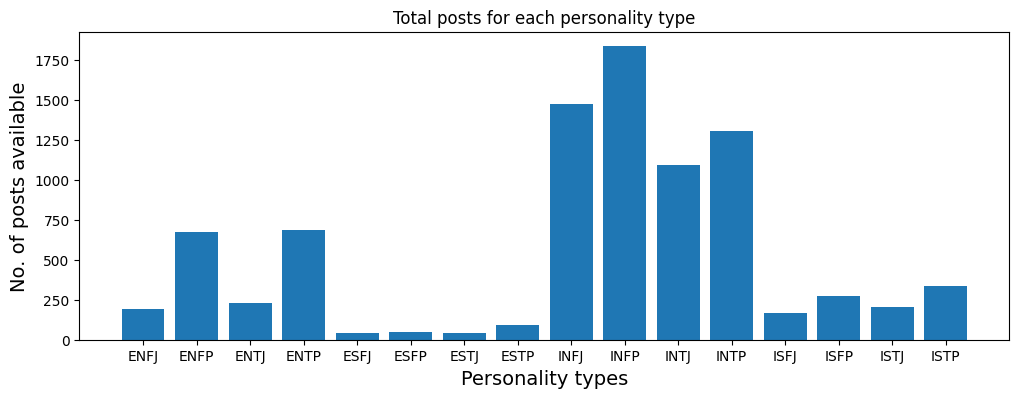

In [17]:
# Data visualization for no. of posts for each personality type
# Group by the data using type
df_total = df.groupby(['type']).count()

plt.figure(figsize = (12,4))
plt.bar(np.array(df_total.index), height = df_total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

We observe that some of the personality types has a lot more data than others, the most common Kaggle users personality is INFP (Introvert Intuition Feeling Perceiving).
We can consider for now that users who comment on social media more frequently are more intoverted, perceptive, and emotional.

In [18]:
#This function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,type,posts,words_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


Since the original dataset only came with 2 features, the Type and 50 posts for each person, lets create additional features for exploring & analysing our dataset.Added two more parameter words per comments and Variance of words


/var/folders/s5/r__yh4p17f12tlyfs6w_46xm0000gn/T/ipykernel_62212/2183922515.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")


Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

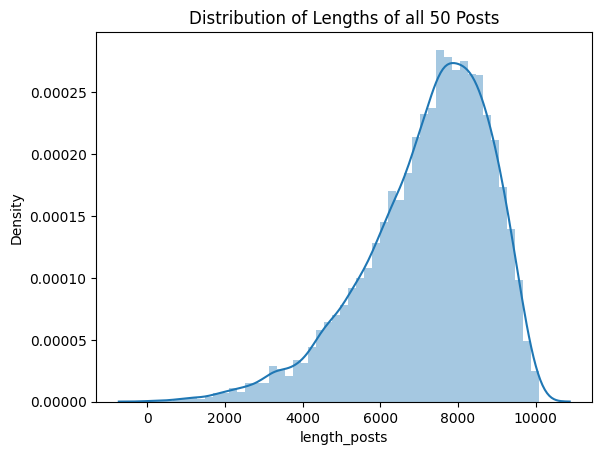

In [19]:
# Add length of the post 
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

We can see that most no of lengthly posts have between 7000-9000 words

In [20]:
#Finding the most common words in all posts.Top 20
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(20) 

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496)]

In [21]:

# Convert the list to a DataFrame
df_words = pd.DataFrame(Counter(words).most_common(20) , columns=['Word', 'Count'])
df_words.head()


,Word,Count
0,I,387957
1,to,290168
2,the,270699
3,a,230918
4,and,219498


Text(0.5, 1.0, 'Posts with Common word count')

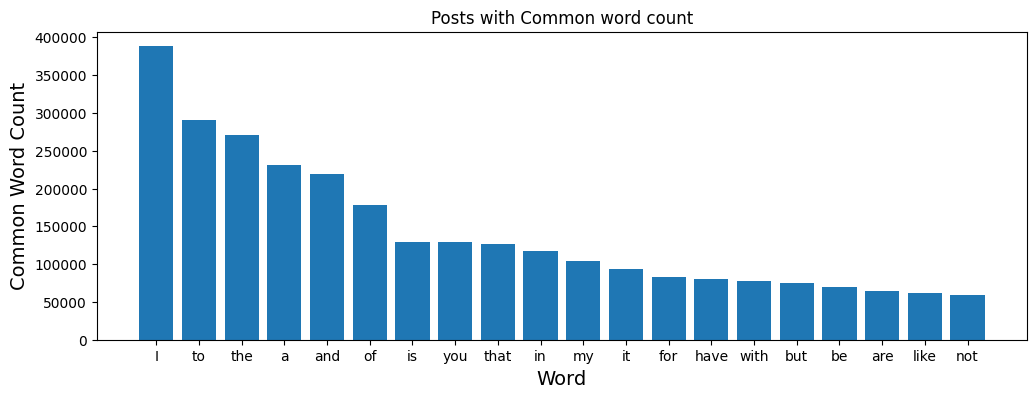

In [22]:
# Barplot for commonly used words.
plt.figure(figsize = (12,4))
plt.bar(df_words['Word'], height = df_words['Count'],)
plt.xlabel('Word', size = 14)
plt.ylabel('Common Word Count', size = 14)
plt.title('Posts with Common word count')

#### Next Steps:
#### Feature Engineering:
    Convert the text data into numerical features that machine learning models can understand. 
#### Label Encoding:
    Encode the categorical MBTI personality types into numerical labels. For example, convert "INFP" to 1,
    "ENFJ" to 2, and so on.
#### Data Splitting:
    Split the dataset into training, validation, and test sets. 
#### Model Selection:
    Choose a machine learning model suitable for text classification tasks. Common choices include logistic regression, support vector machines, random forests, and neural networks
#### Model Training:
    Train the selected model on the training dataset using the prepared text features and the corresponding MBTI labels.

In [23]:
# Print dataset

df.head(10)

,type,posts,words_per_comment,variance_of_word_counts,length_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,4652
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,7053
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,5265
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,6271
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,6111
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,29.82,97.7200,8589
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",26.58,151.3664,7916
7,INTJ,'I tend to build up a collection of things on ...,24.46,174.7664,6900
8,INFJ,"I'm not sure, that's a good question. The dist...",14.76,207.1124,5325
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,24.66,145.6704,7573


#### Counting the no. of users and posts in the given MBTI Kaggle dataset

In [24]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:5]

/var/folders/s5/r__yh4p17f12tlyfs6w_46xm0000gn/T/ipykernel_62212/4195799907.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for post in posts[1].split("|||"):
/var/folders/s5/r__yh4p17f12tlyfs6w_46xm0000gn/T/ipykernel_62212/4195799907.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_posts.append((posts[0], post))


Number of users 8675
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

* It is inferenced that a lot of hyperlinks are presnt in these posts
* It is safe to assume that url links do not provide any real information about a user's personality, hence, we need to clean our dataset for these too.

#### Data cleaning & Pre-Processing :

In [25]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))
        #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
data_set = pd.read_csv("/Users/rajibsamanta/Documents/Rajib/College/Sem6_fall_2023/Week6/mbti_1.csv")
new_df = preprocess_text(data_set, remove_special=True)

In [26]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


#### Feature Engineering

In [27]:
print(new_df.shape)


(8466, 3)


In [28]:
new_df.head()

,type,posts,no. of. words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming eo...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other eos...,777
4,ENTJ,youre fired eostokendot thats another silly...,402


#### Splitting into Targets & Features:

In [29]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
# Encode the categorical MBTI personality types into numerical labels. For example, convert "INFP" to 1,"ENFJ" to 2, and so on
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

/var/folders/s5/r__yh4p17f12tlyfs6w_46xm0000gn/T/ipykernel_62212/336629569.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['type of encoding'] = enc.fit_transform(new_df['type'])


In [30]:
new_df.head(15)

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2
5,INTJ,eostokendot science perfect eostokendo...,245,10
6,INFJ,cant draw nails haha eostokendot those w...,970,8
7,INTJ,tend build collection things desktop th...,140,10
8,INFJ,sure thats good question eostokendot dist...,522,8
9,INTP,this position where have actually pe...,130,11


In [31]:
# In natural language processing, useless words are referred to as stop words. 
# The python natural language toolkit library provides a list of english stop words.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
# we use stop_words='english' with CountVectorizer since this just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. 
# will become very important features while they add little meaning to the text. This is an important step in pre-processing as our model can often be improved if you don’t take those words into account.
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(new_df["posts"])
train.shape

(8466, 98555)

In [33]:
new_df.head()

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2


* So now there are 98555 features in our dataset for 8466 rows (users)

#### Model(s) Building

In [34]:
#Splitting into Train & Test Sets , 80-20 split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6772, 98555) (6772,) (1694, 98555) (1694,)


In [35]:
# Random Forest
accuracies = {}
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# make predictions for test data
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.20%


In [36]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.15%


In [37]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.50%


/Users/rajibsamanta/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 17.06%


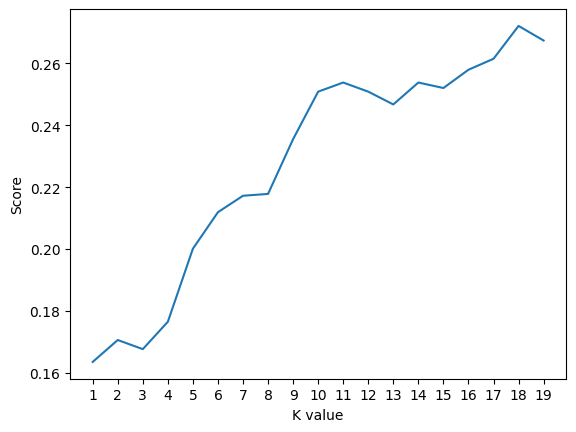

Maximum KNN Score is 27.21%


In [38]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))

In [39]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 43.39%


In [40]:
# SVM Model
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 36.48%


In [41]:
#### Comparing Algorithms
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

,Accuracies(%)
Random Forest,39.197166
XG Boost,58.146399
Logistic Regression,57.497048
KNN,17.060213
Gradient Descent,43.388430
SVM,36.481700


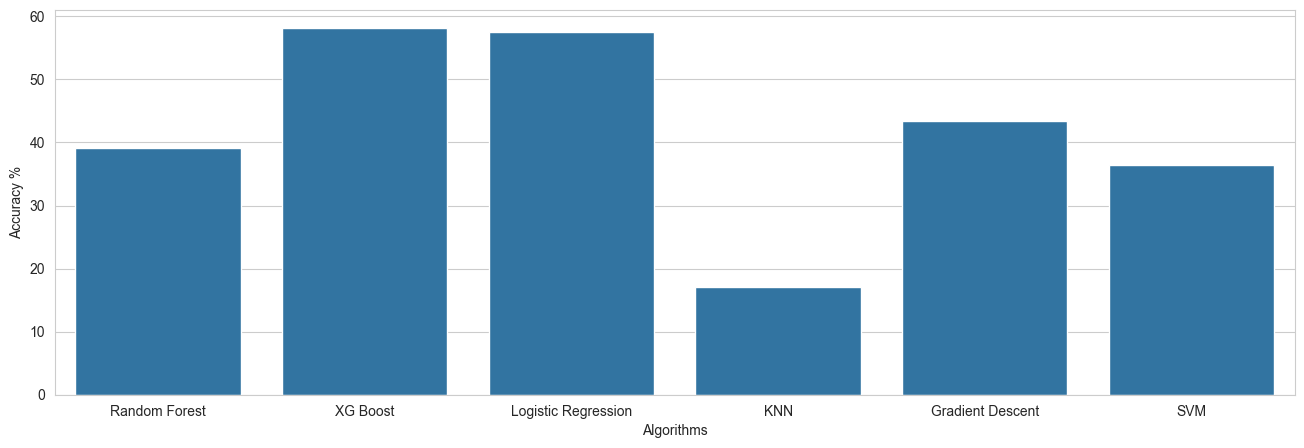

In [42]:
# Bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.show()

* After comparing all the ML models, Logistic Regression model has highest accuracy 57.925072. So will consider this model as Personality Predictor.

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

* Introversion (I) – Extroversion (E)
* Intuition (N) – Sensing (S)
* Thinking (T) – Feeling (F)
* Judging (J) – Perceiving (P)

In [43]:
new_df.head()

,type,posts,no. of. words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming eo...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other eos...,777,10
4,ENTJ,youre fired eostokendot thats another silly...,402,2


In [44]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8466 entries, 0 to 8674
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   type              8466 non-null   object
 1   posts             8466 non-null   object
 2   no. of. words     8466 non-null   int64 
 3   type of encoding  8466 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 330.7+ KB


ADD columns for personality type indicators

In [45]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = new_df.join(new_df.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,no. of. words,type of encoding,IE,NS,TF,JP
0,INFJ,enfp intj moments sportscenter plays...,430,8,1,1,0,1
1,ENTP,finding lack these posts very alarming eo...,803,3,0,1,1,0
2,INTP,good course which know thats bles...,253,11,1,1,1,0
3,INTJ,dear intp enjoyed conversation other eos...,777,10,1,1,1,1
4,ENTJ,youre fired eostokendot thats another silly...,402,2,0,1,1,1


Using the above code, if a person has I, N, T and J, the value across the 4 axis of MBTI i.e. IE, NS, TF and JP respectively, will be 1. Else 0.
This will help us calculate for e.g. how many Introvert posts are present v/s how many Extrovert posts are presnt, out of all the given entries in our labelled Kaggle dataset. This is done in order to extplore the dataset for all the individual Personality Indices of MBTI

* Counting No. of posts in one class / Total no. of posts in the other class

In [46]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1930  /  6536
Intuition (N) / Sensing (S):		 1178  /  7288
Thinking (T) / Feeling (F):		 4556  /  3910
Judging (J) / Perceiving (P):		 5100  /  3366


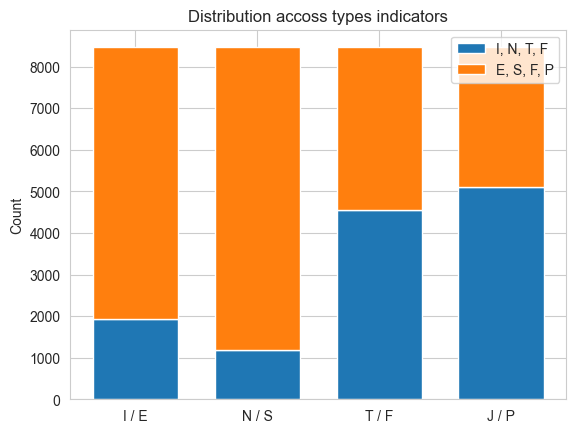

In [47]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

* We can compare this with the fact that Introverts are a minority, making up roughly 16 percent of people. Eventhough among introverts.
* While the population is split roughly 50/50 on the other dimensions, a full 70% of people show a preference for Sensing over Intuition when taking a personality test. Because Intuitives are the minority, the onus is on them to adjust to the Sensor way of thinking.

* The differences between Judging and Perceiving are probably the most marked differences of all the four preferences. People with strong Judging preferences might have a hard time accepting people with strong Perceiving preferences, and vice-versa. On the other hand, a "mixed" couple can complement each other very well, if they have developed themselves enough to be able to accept each other's differences.

#### Plot Features Correlation Heatmap

<Axes: title={'center': 'Features Correlation Heatmap'}>

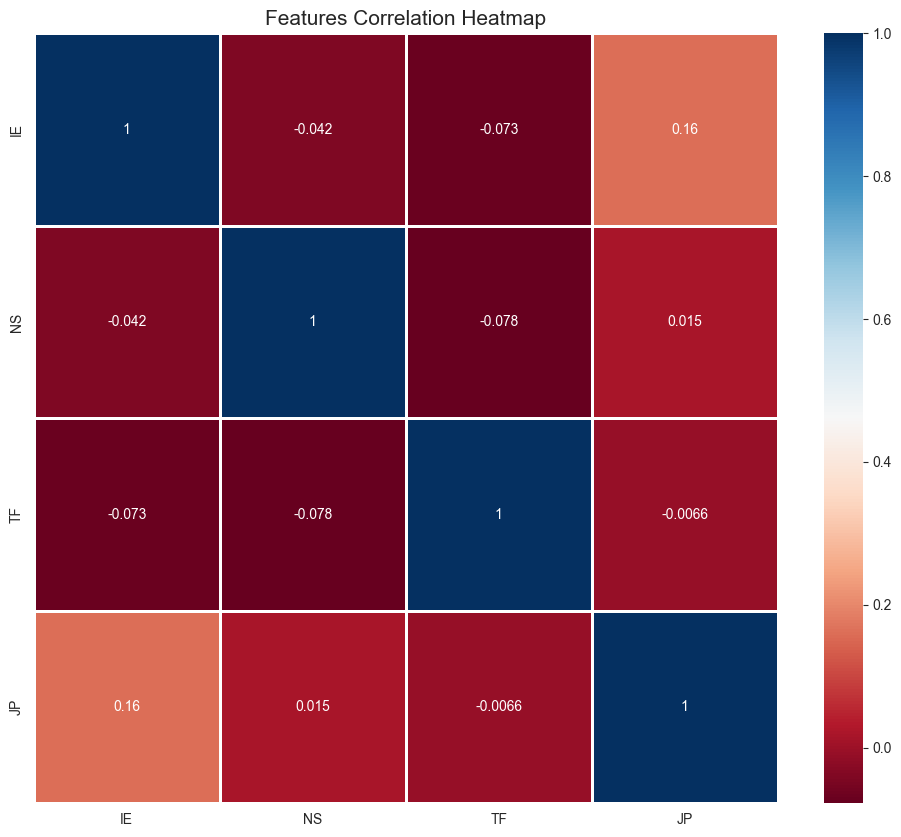

In [48]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

* From this heatmap also, it is unclear if it shows anything valuable for interpretation
* An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. 



In [49]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [50]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rajibsamanta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##### Cleaning of data in the posts

In [51]:
# Remove the stop words for speed 
useless_words = stopwords.words("english")
lemmatiser = WordNetLemmatizer() # Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. 
# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)


  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

     enfp  intj moments   sportscenter    plays   pranks   what  been  most lifechanging experience  your life eostokenquest        repeat  most  today eostokendot      perc experience immerse  eostokendot     last thing  infj friend posted   facebook before committing suicide  next  eostokendot  rest  peace     hello enfj eostokendot  sorry  hear  your distress eostokendot   only natural   relationship    perfection   time  every moment  existence eostokendot    figure  hard times  times  growth  eostokendot  eostokendot  eostokendot          eostokendot  eostokendot  eostokendot    welcome  stuff eostokendot     game eostokendot   eostokendot  match eostokendot    prozac wellbrutin  least thirty minutes  moving your legs   dont mean moving them while sitting  your same desk chair weed  moderation maybe  edibles   healthier alternative eostokendot  eostokendot  eostokendot    basically come  with three items youve determined that each type  which

In [52]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8466  and No. of Personalities = 4 


#### Feature Engineering
For our model we vectorize using count vectorizer and tf-idf vectorizer keeping the words appearing btw 10% to 70% of the posts.

In [53]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'action'), (5, 'actually'), (6, 'advice'), (7, 'afraid'), (8, 'agree'), (9, 'almost')]

Using Tf-idf :
Now the dataset size is as below
(8466, 550)


* Therefore we now have 550 features for each user post.

In [54]:
# Splitting into X and Y variable
# X: User Posts in TF-IDF representation
# Y: Personality type in Binarized MBTI form
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [55]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])

X: 1st posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04783275 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05656561 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09298196 0.         0.         0.
 0.         0.         0.05851738 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17762939 0.         0.
 0.10309241 0.         0.         0.05283347 0.         0.
 0.         0.         0.07867578 0.         0.         0.
 0.         0.         0.         0.07959539 0.08203474 0.09769046
 0.         0.         0.         0.         0.         0.
 0.       

#### Training & Evaluating Models

In [56]:
# Posts in tf-idf representation
X = X_tfidf

In [57]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.77%
NS: Intuition (N) / Sensing (S) Accuracy: 85.47%
FT: Feeling (F) / Thinking (T) Accuracy: 69.79%
JP: Judging (J) / Perceiving (P) Accuracy: 59.84%


In [58]:
#XGBoost model for MBTI dataset 
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 75.48%
NS: Intuition (N) / Sensing (S) Accuracy: 84.97%
FT: Feeling (F) / Thinking (T) Accuracy: 69.58%
JP: Judging (J) / Perceiving (P) Accuracy: 59.77%


In [59]:
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.45%
NS: Intuition (N) / Sensing (S) Accuracy: 85.43%
FT: Feeling (F) / Thinking (T) Accuracy: 72.19%
JP: Judging (J) / Perceiving (P) Accuracy: 61.52%


* Out of all the models, seen above we see that on an average Random Forest model gives relatively good performance

### Now test some sample personality prediction using Random Forest model
#### Personality Prediction 1 - a poem 
"Bird-Understander" by Craig Arnold

In [60]:
my_posts = """ These are your own words
your way of noticing
and saying plainly
of not turning away
from hurt

you have offered them 
to me    I am only 
giving them back 

if only I could show you
how very useless 
they are not"""
mydata = pd.DataFrame(data={'type': ['INFP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [61]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
result = []
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
print("The result is: ", translate_back(result))

The result is:  INFJ


#### Pesonality Prediction 2 - short essay

In [62]:
my_posts  = """For many years, I have been interested in studying international relations. My interest in pursuing this field stems from several factors which have affected me. First, I have been exposed to international affairs throughout my life. With my father and two of my brothers in the Saudi Foreign Service, I have grown up under the shadow of inter-national affairs. Second, I am fascinated by history, economics, and diplomacy. I believe, through the study of international relations, I can effectively satisfy my curiosity in these fields. A third factor which has affected my interest in international relations is patriotism. Through the Foreign Service, I would not only have the opportunity to serve my country, but also have the chance to help bridge gaps between my country and others. Finally, as a Saudi living abroad, I have been bridging cultures throughout my life. This experience has taught me to look for differences to compromise and similarities to synthesize in order to balance different cultures. In short, I believe that my experiences in life, combined with a rigorous academic education, will enable me to pursue a successful career in the Saudi Foreign Service."""
mydata = pd.DataFrame(data={'type': ['ENTP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [63]:
# make predictions for test data
result = []
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
print("The result is: ", translate_back(result))

The result is:  INTP


#### Personality Prediction 3 - Job application cover letter

In [64]:


my_posts  = """Dear Mr. Hennessy, My name is John Young, and I’m applying for a software engineering position at your company. I’m excited about your organization’s mission to change the world, and I’m passionate about your tech stack that includes Scala, Java, React, and Python, all languages I’ve used in the past. 

Recently, I took a year-long hiatus to aid my friend who launched a startup accelerator. During that time, I learned quite a bit about business strategy and going from zero to one hundred while working on a very limited budget. I’m confident that I can turn those skills into new products for your company. 

I’m prepared to get back into the game and restart my career as a software engineer in your beautiful city. I’m positive that I’m the perfect person to lead your middle-out engineering team. I would love to schedule a meeting and discuss this further. """
mydata = pd.DataFrame(data={'type': ['ENTP'], 'posts': [my_posts]})
my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)
my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [65]:
# make predictions for test data
result = []
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
print("The result is: ", translate_back(result))

The result is:  INFP
